# Instruction to lab work # 1

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Task description

In [140]:
STUDENT_NO = 23

# Real datasets examples

(you can use any you find / collect manually)

# Import dependencies

In [31]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# Helping functions

In [123]:
def generate_regression_data(
    n_samples=50, 
    n_features=1, 
    mode='linear', 
    noise=2.0, 
    n_outliers=5, 
    random_seed=42, 
    return_coef=False
):
    """
    Generates data for regression tasks, compatible with scikit-learn.

    :param n_samples: The total number of data points to generate.
    :param n_features: The number of features for the dataset.
    :param mode: The underlying pattern of the data. Can be 'linear' or 'nonlinear'.
    :param noise: The standard deviation of Gaussian noise added to the y-values.
    :param n_outliers: The number of outlier points to add to the dataset.
    :param random_seed: A seed for the random number generator for reproducibility.
    :param return_coef: If True, also returns the true coefficients of the generative model.
    :returns: A tuple (X, y) or (X, y, coefficients) if return_coef is True.
              X is the feature matrix of shape (n_samples, n_features).
              y is the target vector of shape (n_samples,).
              coefficients is a dictionary with 'weights' and 'intercept'.
    """
    
    np.random.seed(random_seed)

    X = np.random.rand(n_samples, n_features) * 10 - 5

    true_intercept = 0
    true_weights = np.zeros(n_features)
    
    if mode == 'linear':
        true_intercept = np.random.uniform(-3, 3)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        y_true = np.dot(X, true_weights) + true_intercept
    elif mode == 'nonlinear':
        if n_features < 1:
            raise ValueError("Nonlinear mode requires at least 1 feature.")
        
        true_intercept = np.random.uniform(-15, 15)
        true_weights = np.random.uniform(-5, 5, size=n_features)
        
        y_true = true_weights[0] * 20 * np.sin(X[:, 0]*1.5) + true_intercept
        
        if n_features > 1:
             y_true += np.dot(X[:, 1:], true_weights[1:])
    else:
        raise ValueError("Mode must be either 'linear' or 'nonlinear'")

    y = y_true + np.random.normal(scale=noise, size=n_samples)

    if n_outliers > 0:
        outlier_indices = np.random.choice(n_samples, n_outliers, replace=False)
        outlier_offset = (np.random.rand(n_outliers) - 0.5) * 30 * (noise + 1)
        y[outlier_indices] += outlier_offset

    if return_coef:
        coefficients = {'weights': true_weights, 'intercept': true_intercept}
        return X, y, coefficients
    else:
        return X, y

In [77]:
def plot_regression_model(
    X, 
    y, 
    weights=None,
    intercept=None, 
    title="Regression Model Visualization",
):
    """
    Visualizes regression data and model performance.

    If the data has one feature, it plots the data points and the regression line.
    If the data has multiple features, it plots the model's predicted vs. actual values.

    :param X: The feature matrix, shape (n_samples, n_features).
    :param y: The target vector, shape (n_samples,).
    :param weights: The model's feature weights (coefficients).
    :param intercept: The model's intercept.
    :param title: The title for the plot.
    :returns: None. Displays a matplotlib plot.
    """
    
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n_features = X.shape[1]
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    model_provided = weights is not None and intercept is not None

    if n_features == 1:
        ax.scatter(X, y, c='cornflowerblue', alpha=0.7, edgecolors='k', label='Data Points')
        
        if model_provided:
            x_line = np.linspace(X.min(), X.max(), 200)
            y_line = x_line * weights[0] + intercept
            label = f'Model: y = {weights[0]:.2f}x + {intercept:.2f}'
            ax.plot(x_line, y_line, color='crimson', linewidth=2.5, label=label)

        ax.set_xlabel("Feature (X)", fontsize=12)
        ax.set_ylabel("Target (y)", fontsize=12)

    else: # n_features > 1
        if not model_provided:
            print("Cannot visualize raw multi-feature data. Please provide model weights and intercept to generate a plot.")
            plt.close(fig)
            return

        y_pred = np.dot(X, weights) + intercept
        
        ax.scatter(y, y_pred, c='cornflowerblue', alpha=0.7, edgecolors='k')
        
        perfect_fit_line = np.linspace(min(y.min(), y_pred.min()), max(y.max(), y_pred.max()), 100)
        ax.plot(perfect_fit_line, perfect_fit_line, color='crimson', linestyle='--', linewidth=2.5, label='Perfect Fit (y_pred = y_true)')
        
        ax.set_xlabel("Actual Values (y_true)", fontsize=12)
        ax.set_ylabel("Predicted Values (y_pred)", fontsize=12)
        ax.legend(fontsize=11)

    ax.set_title(title, fontsize=14, weight='bold')
    plt.show()

In [58]:
def plot_sklearn_regression(model, X, y, title="Model Performance", step=0.01):
    """
    Visualizes the performance of a trained scikit-learn regression model.

    If X has one feature, it plots the data and the model's line point-by-point.
    If X has multiple features, it plots the model's predicted vs. actual values.

    :param model: A trained scikit-learn regressor object (e.g., LinearRegression, Ridge).
    :param X: The feature matrix, shape (n_samples, n_features).
    :param y: The true target vector, shape (n_samples,).
    :param title: The title for the plot.
    :param step: The precision delta for drawing the model's line in the 1D case.
    :returns: None. Displays a matplotlib plot.
    """
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n_features = X.shape[1]
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 7))

    if n_features == 1:
        ax.scatter(X, y, c='cornflowerblue', alpha=0.6, edgecolors='k', label='Actual Data')
        
        # --- Updated Section ---
        x_min, x_max = X.min(), X.max()
        padding = (x_max - x_min) * 0.05
        
        # Create X-records point-by-point using the specified step/precision
        x_line = np.arange(x_min - padding, x_max + padding, step).reshape(-1, 1)
        
        # Get the corresponding y-values from the model
        y_line = model.predict(x_line)
        # --- End Updated Section ---
        
        ax.plot(x_line, y_line, color='crimson', linewidth=1.5, label='Model Prediction Line')
        ax.set_xlabel("Feature (X)", fontsize=12)
        ax.set_ylabel("Target (y)", fontsize=12)

    else: # Multi-feature case
        y_pred = model.predict(X)
        
        ax.scatter(y, y_pred, c='cornflowerblue', alpha=0.6, edgecolors='k')
        
        perfect_fit_line = np.linspace(min(y.min(), y_pred.min()), max(y.max(), y_pred.max()), 100)
        ax.plot(perfect_fit_line, perfect_fit_line, color='crimson', linestyle='--', linewidth=2, label='Perfect Fit')
        
        ax.set_xlabel("Actual Values", fontsize=12)
        ax.set_ylabel("Predicted Values", fontsize=12)

    ax.legend(fontsize=11)
    ax.set_title(title, fontsize=14, weight='bold')
    plt.show()

In [66]:
def evaluate_regression_model(y_true, X, model, print_results=True):
    """
    Calculates and optionally prints metrics for a given regression model.

    This function can accept a scikit-learn model, a np.poly1d object,
    or a list of coefficients.

    :param y_true: The actual target values.
    :param X: The feature matrix.
    :param model: A trained sklearn model, a np.poly1d object, or a list of coefficients.
    :param print_results: If True, prints the metrics to the console.
    :returns: A dictionary containing the calculated metrics.
    """
    
    y_pred = None
    
    # --- Determine prediction method based on model type ---
    if hasattr(model, 'predict'): # Handles scikit-learn models
        y_pred = model.predict(X)
    elif isinstance(model, (list, np.ndarray, np.poly1d)): # Handles weights and poly1d objects
        poly_model = np.poly1d(model)
        if X.ndim > 1 and X.shape[1] > 1:
            print("Warning: Manual weights are being applied to the first feature of X only.")
        y_pred = poly_model(X[:, 0] if X.ndim > 1 else X)
    else:
        raise TypeError("Model type not supported. Please provide a scikit-learn model or a list of weights.")

    # --- Calculate metrics ---
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred)
    }

    if print_results:
        print("----- 📈 Model Evaluation -----")
        print(pd.Series(metrics).to_string(float_format="%.4f"))
        print("-----------------------------")

    return metrics

# Section 1: experiments on artificial data

**More advanced task** (+1 point): modify my code to work with more complex functions for regression (linear, polynomial, sin, cos, and their combination). Feel free to use as complex function as you could found.

## 1.1. Tuning manual Linear Regression 

Just change coefficients of the Linear model and observe changes in loss function

In [145]:
# Generating data
X_lin, y_lin = generate_regression_data(
    n_samples=250, 
    n_features=1, 
    mode='linear', 
    noise=5.0, 
    n_outliers=7, 
    random_seed=STUDENT_NO, 
    return_coef=False
)

----- 📈 Model Evaluation -----
MAE      58.6518
MSE    5953.0130
RMSE     77.1558
R2     -714.0052
-----------------------------


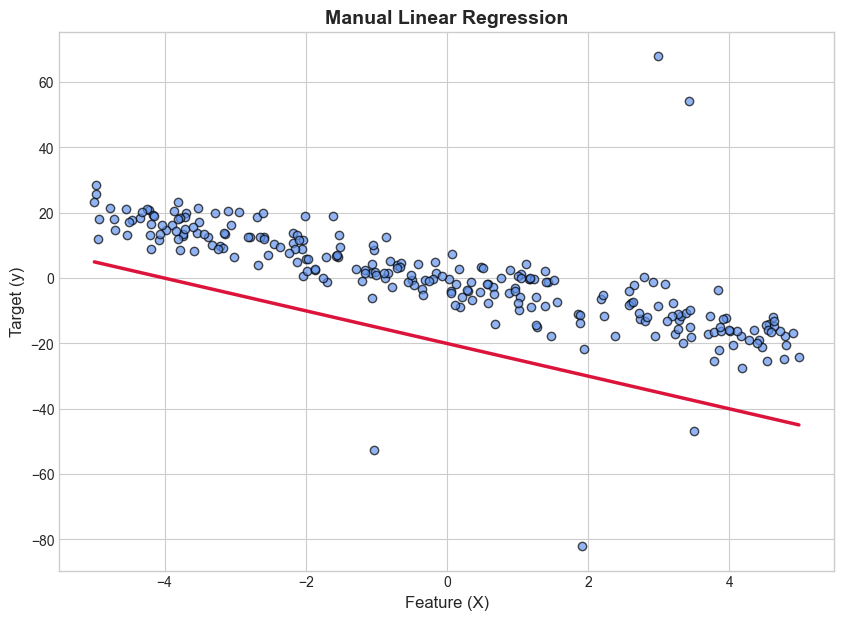

In [146]:
# Example of performing experiments
lin_model_weights = [-5, -20]
evaluate_regression_model(X_lin, y_lin, model=lin_model_weights, print_results=True)
plot_regression_model(X_lin, y_lin, 
                      weights=[lin_model_weights[0], ], 
                      intercept=lin_model_weights[1],
                      title='Manual Linear Regression')

## 1.2. Tuning Linear Regression on non-linear data

Just change coefficients of the Linear model and observe changes in loss function

In [152]:
# Generating data
X_nonlin, y_nonlin = generate_regression_data(
    n_samples=300, 
    n_features=1, 
    mode='nonlinear', 
    noise=5.0, 
    n_outliers=10, 
    random_seed=STUDENT_NO, 
    return_coef=False
)

----- 📈 Model Evaluation -----
MAE      112.3467
MSE    20090.4955
RMSE     141.7409
R2     -2413.2631
-----------------------------


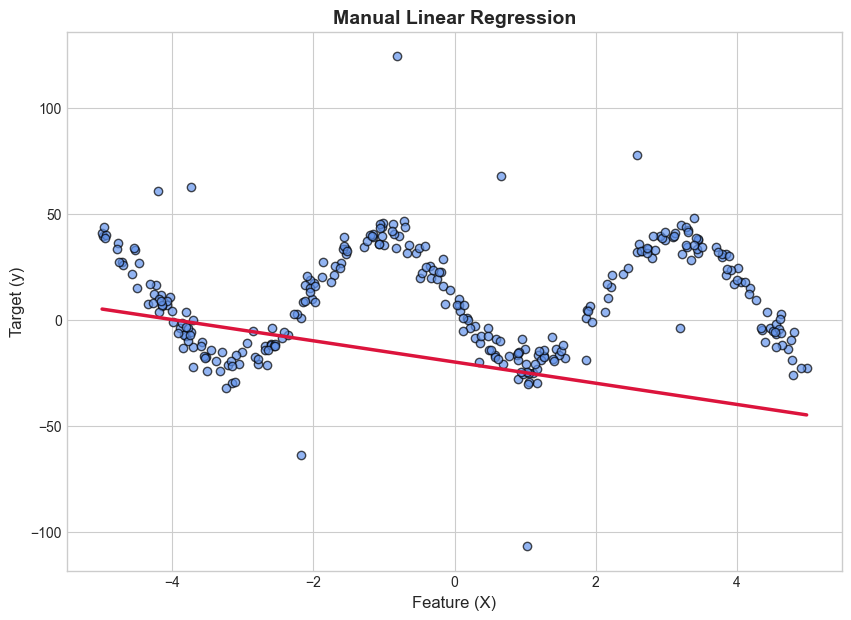

In [153]:
# Example of performing experiments
lin_model_weights = [-5, -20]
evaluate_regression_model(X_nonlin, y_nonlin, model=lin_model_weights, print_results=True)
plot_regression_model(X_nonlin, y_nonlin, 
                      weights=[lin_model_weights[0], ], 
                      intercept=lin_model_weights[1],
                      title='Manual Linear Regression')

## 1.3. Configuring various linear models from sklearn library

Try to configure hyperparameters of various linear regression models from sklearn

In [ ]:
from sklearn.linear_model import LinearRegression, HuberRegressor, PoissonRegressor, LogisticRegression

In [ ]:
model = PoissonRegressor()

## 1.4. Configure non-linear models from sklearn library

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Section 2: experiments on real data

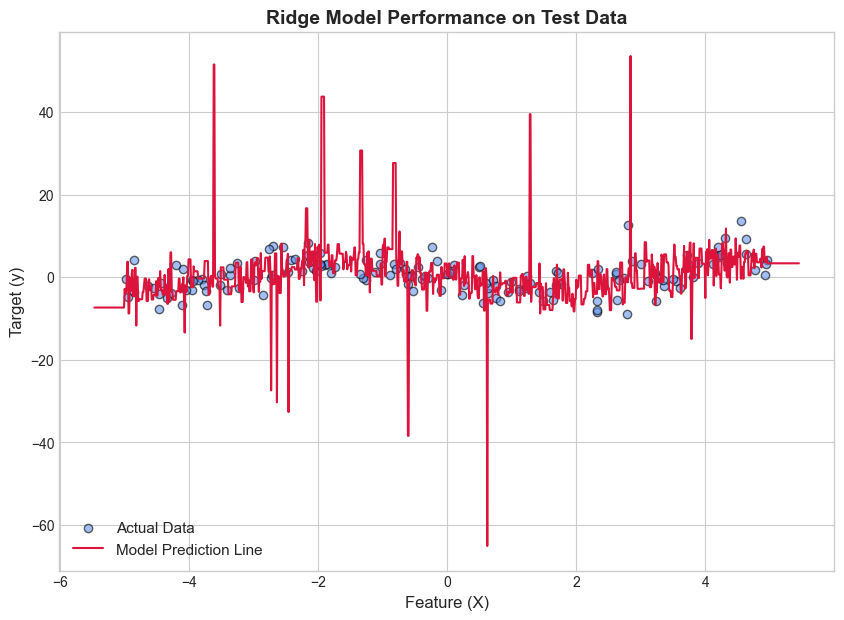

In [62]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


# 1. Generate a multi-feature dataset
X_data, y_data = generate_regression_data(
    # mode='linear',
    mode='nonlinear',
    n_samples=759,
    noise=3.0,
    n_outliers=20,
    random_seed=222,
)

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

# 3. Create and train a scikit-learn Ridge model
ridge_model = DecisionTreeRegressor()
ridge_model.fit(X_train, y_train)

# 4. Use the function to visualize the model's performance on the unseen test data
plot_sklearn_regression(ridge_model, X_test, y_test, title="Ridge Model Performance on Test Data")